In [1]:
# First, add the LatentDynamics directory (which houses the solvers) to the system path.
import  os;
import  sys;

util_Path : str = os.path.join(os.path.join(os.path.pardir, "src"), "Utilities");
sys.path.append(util_Path);

import  math;
import  colorsys;


import  numpy;
import  matplotlib          as      mpl;
import  matplotlib.pyplot   as      plt;
import  seaborn;

from    FirstOrderSolvers  import  RK1, RK2, RK4;


def Initialize_MPL() -> None:
    """
    This function initialize matplotlib's parameter so that the plots it generates are less ugly.
    This function has no arguments or return variables.
    """

    # Now... let's set up plot formatting.
    def scale_lightness(rgb, scale_l):
        # convert rgb to hls
        h, l, s = colorsys.rgb_to_hls(*rgb)

        # manipulate h, l, s values and return as rgb
        return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

    seaborn.set_context(context     = "paper");
    seaborn.set_style(  style       = "darkgrid");
    mpl.rcParams["lines.linewidth"] = 2;
    mpl.rcParams["axes.linewidth"]  = 1.5;
    mpl.rcParams["axes.edgecolor"]  = "black";
    mpl.rcParams["grid.color"]      = "gray";
    mpl.rcParams["grid.linestyle"]  = "dotted";
    mpl.rcParams["grid.linewidth"]  = .67;
    mpl.rcParams["xtick.labelsize"] = 10;
    mpl.rcParams["ytick.labelsize"] = 10;
    mpl.rcParams["axes.labelsize"]  = 11;
    mpl.rcParams["axes.titlesize"]  = 12;
    mpl.rcParams["axes.facecolor"]  = scale_lightness(mpl.colors.ColorConverter.to_rgb("lightgrey"), 1.15);

Initialize_MPL();

### Compute the Numerical Solution

In [2]:
# Set up right hand side
c   : float     = 1.0;
A   : float     = 5.0;
y0  : float     = 2.0;


# F(t, y) = [2A t cos(t^2) + c - y]/[y + 5]
def F(t : float, y : numpy.ndarray):
    return numpy.divide((2*A)*numpy.multiply(t, numpy.cos(numpy.multiply(t, t))) + c*numpy.ones_like(t) - y, t + 5*numpy.ones_like(t));


# Settings.
Y0  : numpy.ndarray = numpy.array([y0], dtype = numpy.float32);
h   : float         = 0.015;
N   : int           = 1000;


# Set up time series
T_1 : numpy.ndarray = numpy.linspace(start = 0, stop = h*N, num = 4*N + 1);
T_2 : numpy.ndarray = numpy.linspace(start = 0, stop = h*N, num = 2*N + 1);
T_4 : numpy.ndarray = numpy.linspace(start = 0, stop = h*N, num = N + 1);


# Get positions, velocities
Y_1 = RK1(f = F, y0 = Y0, t_Grid = T_1);
Y_2 = RK2(f = F, y0 = Y0, t_Grid = T_2);
Y_4 = RK4(f = F, y0 = Y0, t_Grid = T_4);


# Reshape output
Y_1 = Y_1.reshape(-1);
Y_2 = Y_2.reshape(-1);
Y_4 = Y_4.reshape(-1);

### Compute the Exact Solution 

The governing equation is

$$
\begin{aligned}
y'(t)   &= \frac{2 A t \cos(t^2) + c - y(t)}{t + 5} \\
y(0)    &= y_0
\end{aligned}
$$

This is an exact differential equation. Specifically, if we rearrange both sides, we get

$$y'(t)(t + 5) + y(t) - 2 A t \cos(t^2) - c = 0.$$

Let $M : \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ and $N : \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ be defined by

$$
\begin{aligned}
M(t, y) &= t + 5 \\
N(t, y) &= y - 2 A t \cos\left(t^2\right) - c
\end{aligned}
$$

Then, our equation has the form

$$y'(t) M\left(t, y(t)\right) + N\left(t, y(t) \right) = 0.$$

However, notice that 

$$
\begin{aligned}
\tfrac{\partial}{\partial t} M(t, y) &= 1
&= \tfrac{\partial}{\partial y}N(t, y)
\end{aligned}
$$

Thus, the equation is exact. With this in mind, let $P : \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ be defined by

$$P(t, y) = y(t + 5) - A \sin\left(t^2\right) - c(t + 5).$$

Notice that 

$$
\begin{aligned}
\tfrac{\partial}{\partial y}P(t, y) &= t + 5 \\
&= M(t, y)
\end{aligned}
$$

and

$$
\begin{aligned}
\tfrac{\partial}{\partial t}P(t, y) &= y - 2 A t \cos\left(t^2\right) - c \\
&= N(t, y)
\end{aligned}
$$

Therefore, 

$$
\begin{aligned}
0 &= y'(t) M\left(t, y(t)\right) + N\left(t, y(t) \right) \\
&= y'(t) \tfrac{\partial}{\partial y}P\left(t, y(t)\right) + \tfrac{\partial}{\partial t}P\left(t, y(t) \right) \\
&= \tfrac{d}{dt} P\left(t, y(t) \right)
\end{aligned}
$$

Which means that one possible solution is any $y$ such that $P\left(t, y(t)\right) = k$, for some $k \in \mathbb{R}$. 
In other words, we must have

$$y(t) = \frac{A \sin\left(t^2 \right)}{t + 5} + c + \frac{k}{t + 5}.$$

Plugging in $t = 0$ gives 

$$y_0 = y(0) = c + k/5.$$

Or, 

$$k = 5\left(y_0 - c\right)$$

Therefore, the ODE solution is

$$y(t) = \frac{A \sin\left(t^2 \right)}{t + 5} + c + \frac{5\left(y_0 - c \right)}{t + 5}.$$



In [3]:
T   : numpy.ndarray     = numpy.linspace(start = 0, stop = h*N, num = N + 1);

def Solution(T : numpy.ndarray) -> numpy.ndarray:
    #       A sin(t^2)/(t + 5)                                    + c                    + 5(y0 - c)/(t + 5)
    return numpy.divide(A*numpy.sin(numpy.multiply(T, T)), T + 5) + c*numpy.ones_like(T) + numpy.divide((5*(y0 - c))*numpy.ones_like(T), T + 5*numpy.ones_like(T));

Y   : numpy.ndarray = Solution(T);

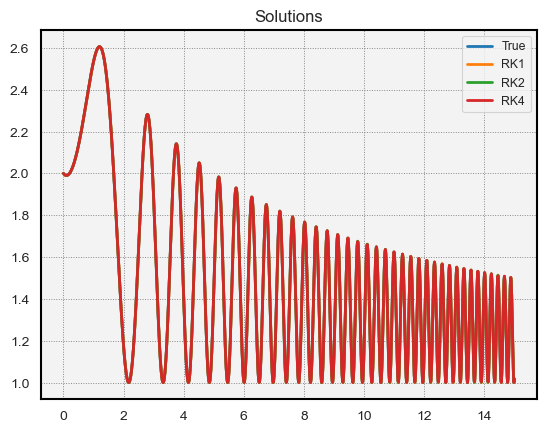

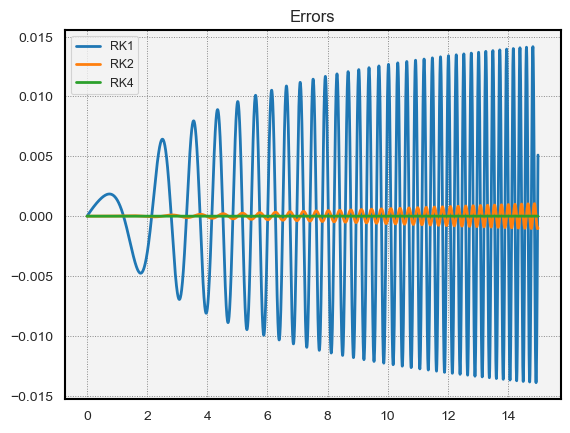

In [4]:
# Displacement plot
plt.figure();
plt.plot(T,       Y,      label = "True");
plt.plot(T_1,     Y_1,    label = "RK1");
plt.plot(T_2,     Y_2,    label = "RK2");
plt.plot(T_4,     Y_4,    label = "RK4");

plt.title("Solutions");
plt.legend();


# Error
plt.figure();

plt.plot(T_1,     Solution(T_1) - Y_1,    label = "RK1");
plt.plot(T_2,     Solution(T_2) - Y_2,    label = "RK2");
plt.plot(T_4,     Solution(T_4) - Y_4,    label = "RK4");

plt.title("Errors");
plt.legend();

plt.show();